# Feature selection using ranked fisher score



This jupyter notebook presents the feature selection using ranked fisher score. We perform fisher score on two different kind of features, one is before applying PCA and another one is after PCA.

## Fisher score implementation

In [1]:
import numpy as np
'''
Researcher: Lei Wang

'''
def fisher_score(features, labels):
    # print('fisher score')
    f_scores = np.zeros(len(features.T))
    classes = np.unique(labels)

    for col in range(len(features.T)):
        c_spread = 0.0 #same class spread
        t_spread = 0.0 #total spread

        mean = np.mean(features[:, col])
        for c in classes:
            #weigth of current class N_c / N
            nc = len(labels[labels == c]) / len(labels)
            #Same class mean and standard deviation of each data column
            # print((labels == c).reshape(-1).tolist())
            c_mean = np.mean(features[(labels == c).reshape(-1).tolist(), col])
            c_std = np.std(features[(labels == c).reshape(-1).tolist(), col])
            c_spread += nc * ((c_mean - mean) ** 2)
            t_spread += nc * ((c_std) ** 2)
        f_scores[col] += c_spread / t_spread
    # sort the fisher vector value and return the index
    # print(f_scores)
    f_scores = np.argsort(f_scores)
    # reverse the vector
    f_scores = f_scores[::-1]
    return f_scores

## Load extracted features (after PCA)

In [2]:
import pandas as pd

# load the extracted features
trajectory_pca = pd.read_csv('iCetana_FV_PCA_features_DT_trajectory.csv')
hog_pca = pd.read_csv('iCetana_FV_PCA_features_DT_hog.csv')
hof_pca = pd.read_csv('iCetana_FV_PCA_features_DT_hof.csv')
mbhx_pca = pd.read_csv('iCetana_FV_PCA_features_DT_mbhx.csv')
mbhy_pca = pd.read_csv('iCetana_FV_PCA_features_DT_mbhy.csv')
mbh_pca = pd.read_csv('iCetana_FV_PCA_features_DT_mbh.csv')

# turn the pandas data into numpy array
trajectory_pca = trajectory_pca.values
hog_pca = hog_pca.values
hof_pca = hof_pca.values
mbhx_pca = mbhx_pca.values
mbhy_pca = mbhy_pca.values
mbh_pca = mbh_pca.values

# load the labels
# dynamic environment labels
env_labels = pd.read_csv('all_labels.csv')
# human/no human motion labels
human_labels = pd.read_csv('human_labels.csv')

env_labels = env_labels.values
human_labels = human_labels.values

## Compute fisher score for feature selection

In [3]:
import math

def keep_f_dim(features, percentage):
    dim = features.shape[1]
    new_dim = math.ceil(dim*percentage)
    
    return new_dim

In [4]:
def feature_selection_fc(features, labels, percentage):
    f_index = fisher_score(features, labels)
    new_dim = keep_f_dim(features, percentage)
    reduced_index = f_index[0:new_dim]
    reduced_features = features[:, reduced_index]
    
    return reduced_features

In [5]:
# at this stage, we keep half of the original feature dimension
percentage = 0.5
labels = env_labels

# compute the fisher score for each individual feature vectors
traj_pca_fc = feature_selection_fc(trajectory_pca, labels, percentage)
hog_pca_fc = feature_selection_fc(hog_pca, labels, percentage)
hof_pca_fc = feature_selection_fc(hof_pca, labels, percentage)
mbhx_pca_fc = feature_selection_fc(mbhx_pca, labels, percentage)
mbhy_pca_fc = feature_selection_fc(mbhy_pca, labels, percentage)
mbh_pca_fc = feature_selection_fc(mbh_pca, labels, percentage)

concate_features_fc = np.concatenate((traj_pca_fc, hog_pca_fc, hof_pca_fc, mbhx_pca_fc, mbhy_pca_fc), axis=1)
print("The concatenated feature dimension is: ", concate_features_fc.shape)

The concatenated feature dimension is:  (270, 478)


In [6]:
concate_features_fc = pd.DataFrame(concate_features_fc)
concate_features_fc.to_csv("concate_pca_fisher_score_features.csv", index=False)

## Uniform Manifold Approximation and Projection

In [7]:
fisher_score_features = pd.read_csv('concate_pca_fisher_score_features.csv')

In [8]:
def colormap(c):
    if c==0:
        color='r'
    elif c==1:
        color='g'
    elif c==2:
        color='b'
    elif c==3:
        color='c'
    elif c==4:
        color='m'
    elif c==5:
        color='k'
    return color

def labelmap(c):
    if c==0:
        label='normal video'
    elif c==1:
        label='illumination'
    elif c==2:
        label='noise video'
    elif c==3:
        label='rain'
    elif c==4:
        label='camera shake'
    elif c==5:
        label='tree wave'
    return label

In [9]:
all_labels = pd.read_csv('all_labels.csv')
human_labels = pd.read_csv('human_labels.csv')

/anaconda3/envs/myenv3.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


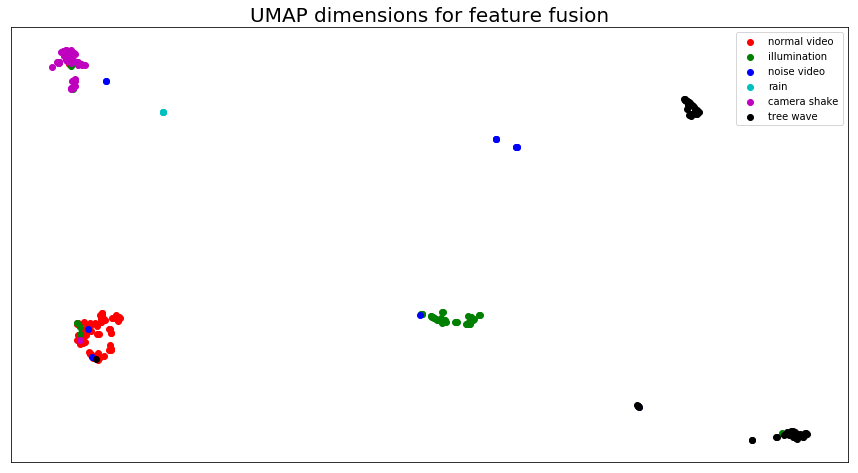

In [10]:
%matplotlib inline
import umap
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15,8)
standard_embedding = umap.UMAP(n_neighbors=15, min_dist=0.0, 
                               n_components=2,random_state=42,
#                               metric='correlation'
                              ).fit_transform(fisher_score_features.values, y = all_labels.values)
x_tsne=standard_embedding[:, 0]
y_tsne=standard_embedding[:, 1]

labels= all_labels.values
#print(labels)

x=np.c_[x_tsne]
y=np.c_[y_tsne]

plt.xticks([])
plt.yticks([])
plt.title('UMAP dimensions for feature fusion', fontsize=20)

seen=set()
for i, j, c in zip(x, y, labels):
    c=int(c)
    plt.scatter(i, j, c=colormap(c), marker="o", cmap='jet', label=labelmap(c) if c not in seen else None)
    seen.add(c)
    # plt.annotate(h, (i,j))
plt.legend()    
plt.show()



## The END